In [1]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/MyDrive/', force_remount = True)

Mounted at /content/MyDrive/


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[0], 'GPU')

Num GPUs Available:  1


In [3]:
!pwd

/content


In [4]:
!ls

MyDrive  sample_data


In [5]:
%cd MyDrive/MyDrive/Colab Notebooks/

/content/MyDrive/MyDrive/Colab Notebooks


In [6]:
!pip install split-folders

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.models import Sequential, load_model
from keras.applications import VGG16
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, zero_one_loss, classification_report
from sklearn.model_selection import train_test_split
from imutils import paths

import matplotlib.pyplot as plt
import seaborn as sb
import splitfolders
import cv2
import random

In [8]:
inputFolder = './image_dataset_(Brain)'
outputFolder = './image_dataset_(Brain)_output'

In [9]:
splitfolders.ratio(inputFolder, outputFolder, seed = 44, ratio = (0.8, 0.0, 0.2))

Copying files: 0 files [00:00, ? files/s]


In [10]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import seaborn as sb
from imutils import paths

trainFolder = os.path.join(inputFolder, 'train')
testFolder = os.path.join(inputFolder, 'test')

# Get image paths separately for train and test
train_imgPaths = list(paths.list_images(trainFolder))
test_imgPaths = list(paths.list_images(testFolder))

print(f"Train images: {len(train_imgPaths)}")
print(f"Test images: {len(test_imgPaths)}")

# Shuffle paths
random.shuffle(train_imgPaths)
random.shuffle(test_imgPaths)

# Get class names dynamically from train folder
classes = sorted(os.listdir(trainFolder))  # safer and dynamic
print("Classes:", classes)

IMGSIZE = 128

X_train, y_train, img_names = [], [], []
X_test, y_test = [], []

# Processing training data
for imgPath in train_imgPaths:
    className = imgPath.split(os.path.sep)[-2]
    # img = cv2.imread(imgPath)
    # print(f"Processing: {imgPath}")
    img = cv2.imread(imgPath)
    if img is None:
        print(f"Warning: Failed to read image {imgPath}")
        continue  # skip this image

    img = cv2.resize(img, (IMGSIZE, IMGSIZE))
    X_train.append(img)
    y_train.append(classes.index(className))
    img_names.append(os.path.basename(imgPath))

Train images: 16022
Test images: 4000
Classes: ['brain_glioma', 'brain_menin', 'brain_pituitary', 'no_tumor']


In [11]:
for imgPath in test_imgPaths:
    className = imgPath.split(os.path.sep)[-2]
    img = cv2.imread(imgPath)
    img = cv2.resize(img, (IMGSIZE, IMGSIZE))
    X_test.append(img)
    y_test.append(classes.index(className))

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))


16022 16022
4000 4000


In [12]:

df = pd.DataFrame({
    'File Name' : img_names,
    'Category' : y_train #y
})

# print(classes.index('brain_menin'))
# print(classes.index('brain_glioma'))
# print(classes.index('brain_pituitary'))
# print(classes.index('no_tumor'))

print(classes)
df.head()

['brain_glioma', 'brain_menin', 'brain_pituitary', 'no_tumor']


,File Name,Category
0,brain_menin_3504.jpg,1
1,Tr-no_1416.jpg,3
2,brain_glioma_4718.jpg,0
3,brain_glioma_1691.jpg,0
4,no_tumor_val_0092.jpg,3


<Axes: ylabel='count'>

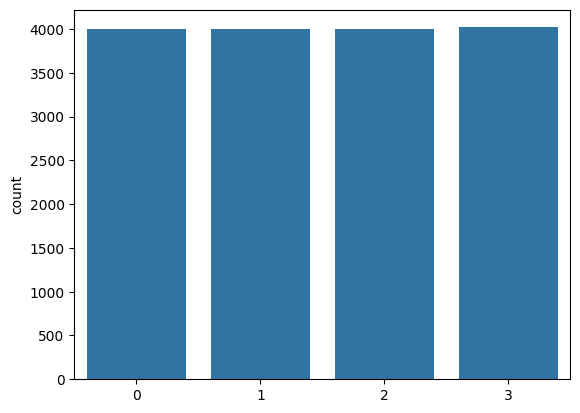

In [13]:

sb.countplot(x = y_train)

<Axes: ylabel='count'>

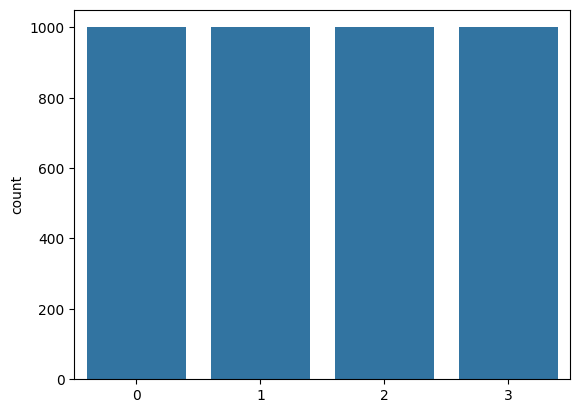

In [14]:
sb.countplot(x = y_test)

In [15]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [16]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16022, 128, 128, 3) (16022,)
(4000, 128, 128, 3) (4000,)


In [17]:
input_shape = (IMGSIZE, IMGSIZE, 3) #tuple
num_classes = 4

# Load the pre-trained ResNet50 model (without the top classification layer)
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = input_shape)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()

model.add(base_model)
model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
results = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 20, batch_size = 32, callbacks = [early_stopping])
# val_loss, val_acc = resnet_model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - accuracy: 0.7430 - loss: 1.6159 - val_accuracy: 0.9178 - val_loss: 0.2205
Epoch 2/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 65s 76ms/step - accuracy: 0.9047 - loss: 0.2704 - val_accuracy: 0.9298 - val_loss: 0.1903
Epoch 3/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - accuracy: 0.9262 - loss: 0.2072 - val_accuracy: 0.9495 - val_loss: 0.1389
Epoch 4/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.9480 - loss: 0.1402 - val_accuracy: 0.9597 - val_loss: 0.1095
Epoch 5/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.9611 - loss: 0.1120 - val_accuracy: 0.9553 - val_loss: 0.1179
Epoch 6/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.9646 - loss: 0.1075 - val_accuracy: 0.9610 - val_loss: 0.1135
Epoch 7/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.9687 - loss: 0.0850 - val_accuracy: 0.9707 - val_loss: 0.0825
Epoch 8/20
501/501 ━━━━━━━━━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,131,150 (80.61 MB)

 Trainable params: 2,138,820 (8.16 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 4,277,642 (16.32 MB)

In [18]:
model.save('./vgg_model.keras')

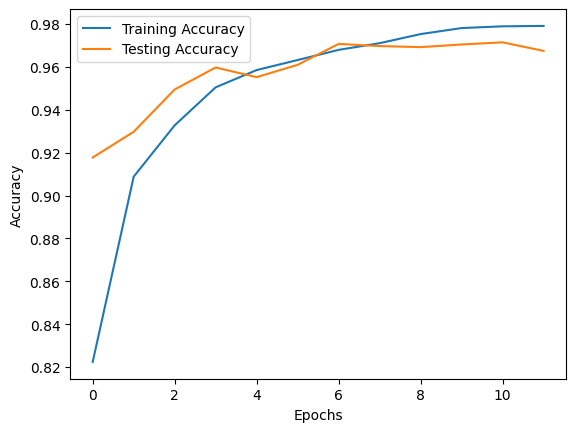

In [19]:

plt.plot(results.history['accuracy'], label = 'Training Accuracy')
plt.plot(results.history['val_accuracy'], label = 'Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

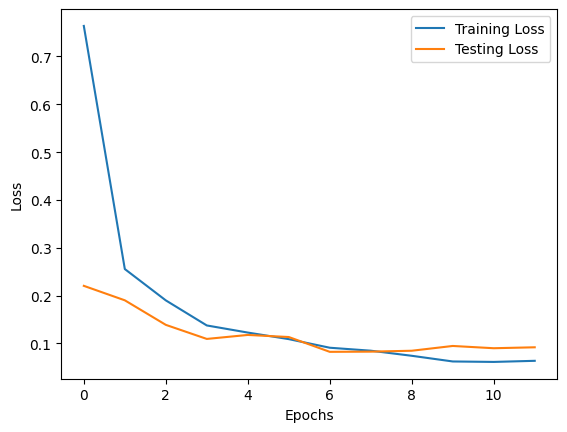

In [20]:

plt.plot(results.history['loss'], label = 'Training Loss')
plt.plot(results.history['val_loss'], label = 'Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

['brain_glioma', 'brain_menin', 'brain_pituitary', 'no_tumor']
[3 2 3 2 3 1 2 2 3 1 2 3 1 0 1 3 1 0 0 1 0 3 0 3 1] 

[[8.5166140e-27 1.1406289e-40 0.0000000e+00 1.0000000e+00]
 [2.7272387e-13 1.4954802e-05 9.9998510e-01 1.6237614e-15]
 [4.3444320e-15 1.8474802e-23 2.7788778e-26 1.0000000e+00]
 [1.0230982e-10 1.5452494e-04 9.9984550e-01 9.4938098e-13]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [2.9557312e-01 6.2415814e-01 7.9318561e-02 9.5018343e-04]
 [2.2772959e-11 2.6116741e-04 9.9973887e-01 7.3169921e-13]
 [4.9057345e-11 4.7496178e-05 9.9995255e-01 1.2693346e-12]
 [3.1289387e-37 0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [1.8998327e-03 9.9252254e-01 5.5747670e-03 2.8889822e-06]
 [1.2432737e-09 4.8801760e-04 9.9951196e-01 2.0989519e-11]
 [2.7694088e-13 3.3520227e-23 1.0874471e-28 1.0000000e+00]
 [4.4117626e-02 5.5600739e-01 3.9427820e-01 5.5967811e-03]
 [9.9999022e-01 9.8254932e-06 1.8816987e-08 2.0071078e-12]
 [4.6953008e-02 9.2252111e-01 3.0434618e-02 9.1320748e-05

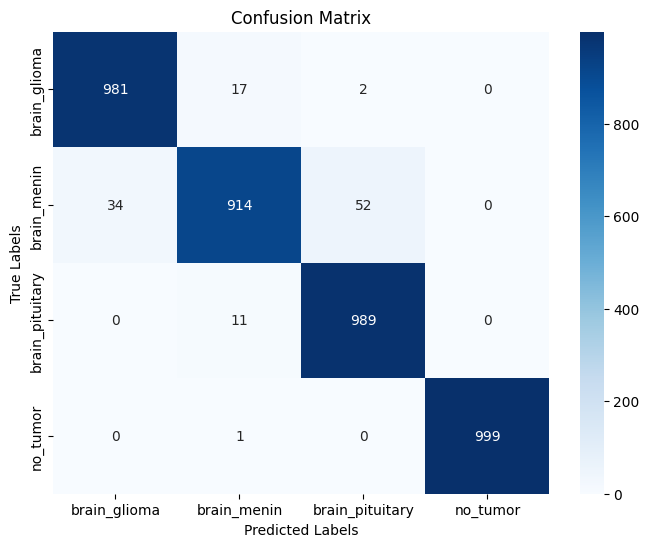

117.0 

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1000
           1       0.97      0.91      0.94      1000
           2       0.95      0.99      0.97      1000
           3       1.00      1.00      1.00      1000

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, zero_one_loss

# your existing code
print(classes)
print(y_test[:25], '\n')
print(y_pred[:25], '\n')

predict = []
for i in range(len(y_pred)):
    predict.append(np.argmax(y_pred[i]))

print(predict[:25], '\n')

cm = confusion_matrix(y_test, predict)
print(cm, '\n')

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

zol = zero_one_loss(y_test, predict, normalize=False)
print(zol, '\n')

cr = classification_report(y_test, predict)
print(cr)



<Figure size 500x500 with 0 Axes>

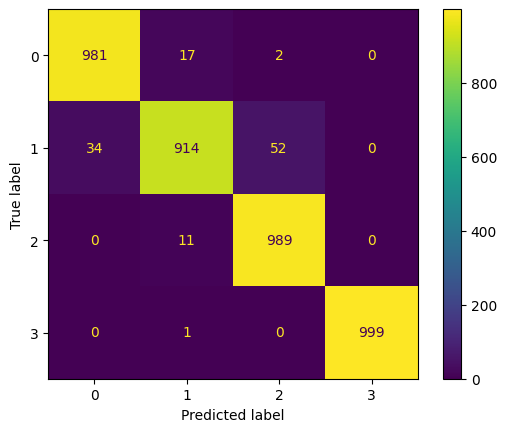

In [22]:
plt.figure(figsize = (5,5))
ConfusionMatrixDisplay(cm).plot()
plt.show()

<Axes: ylabel='count'>

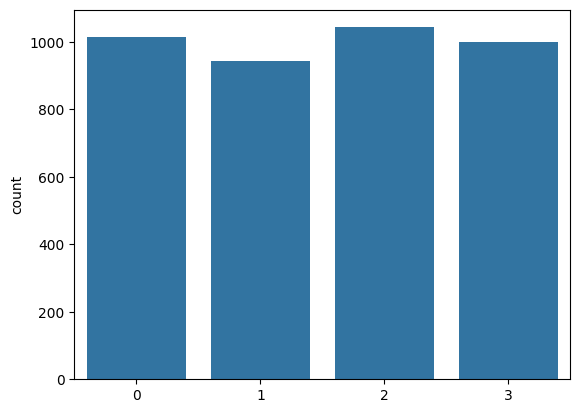

In [23]:
sb.countplot(x = predict)

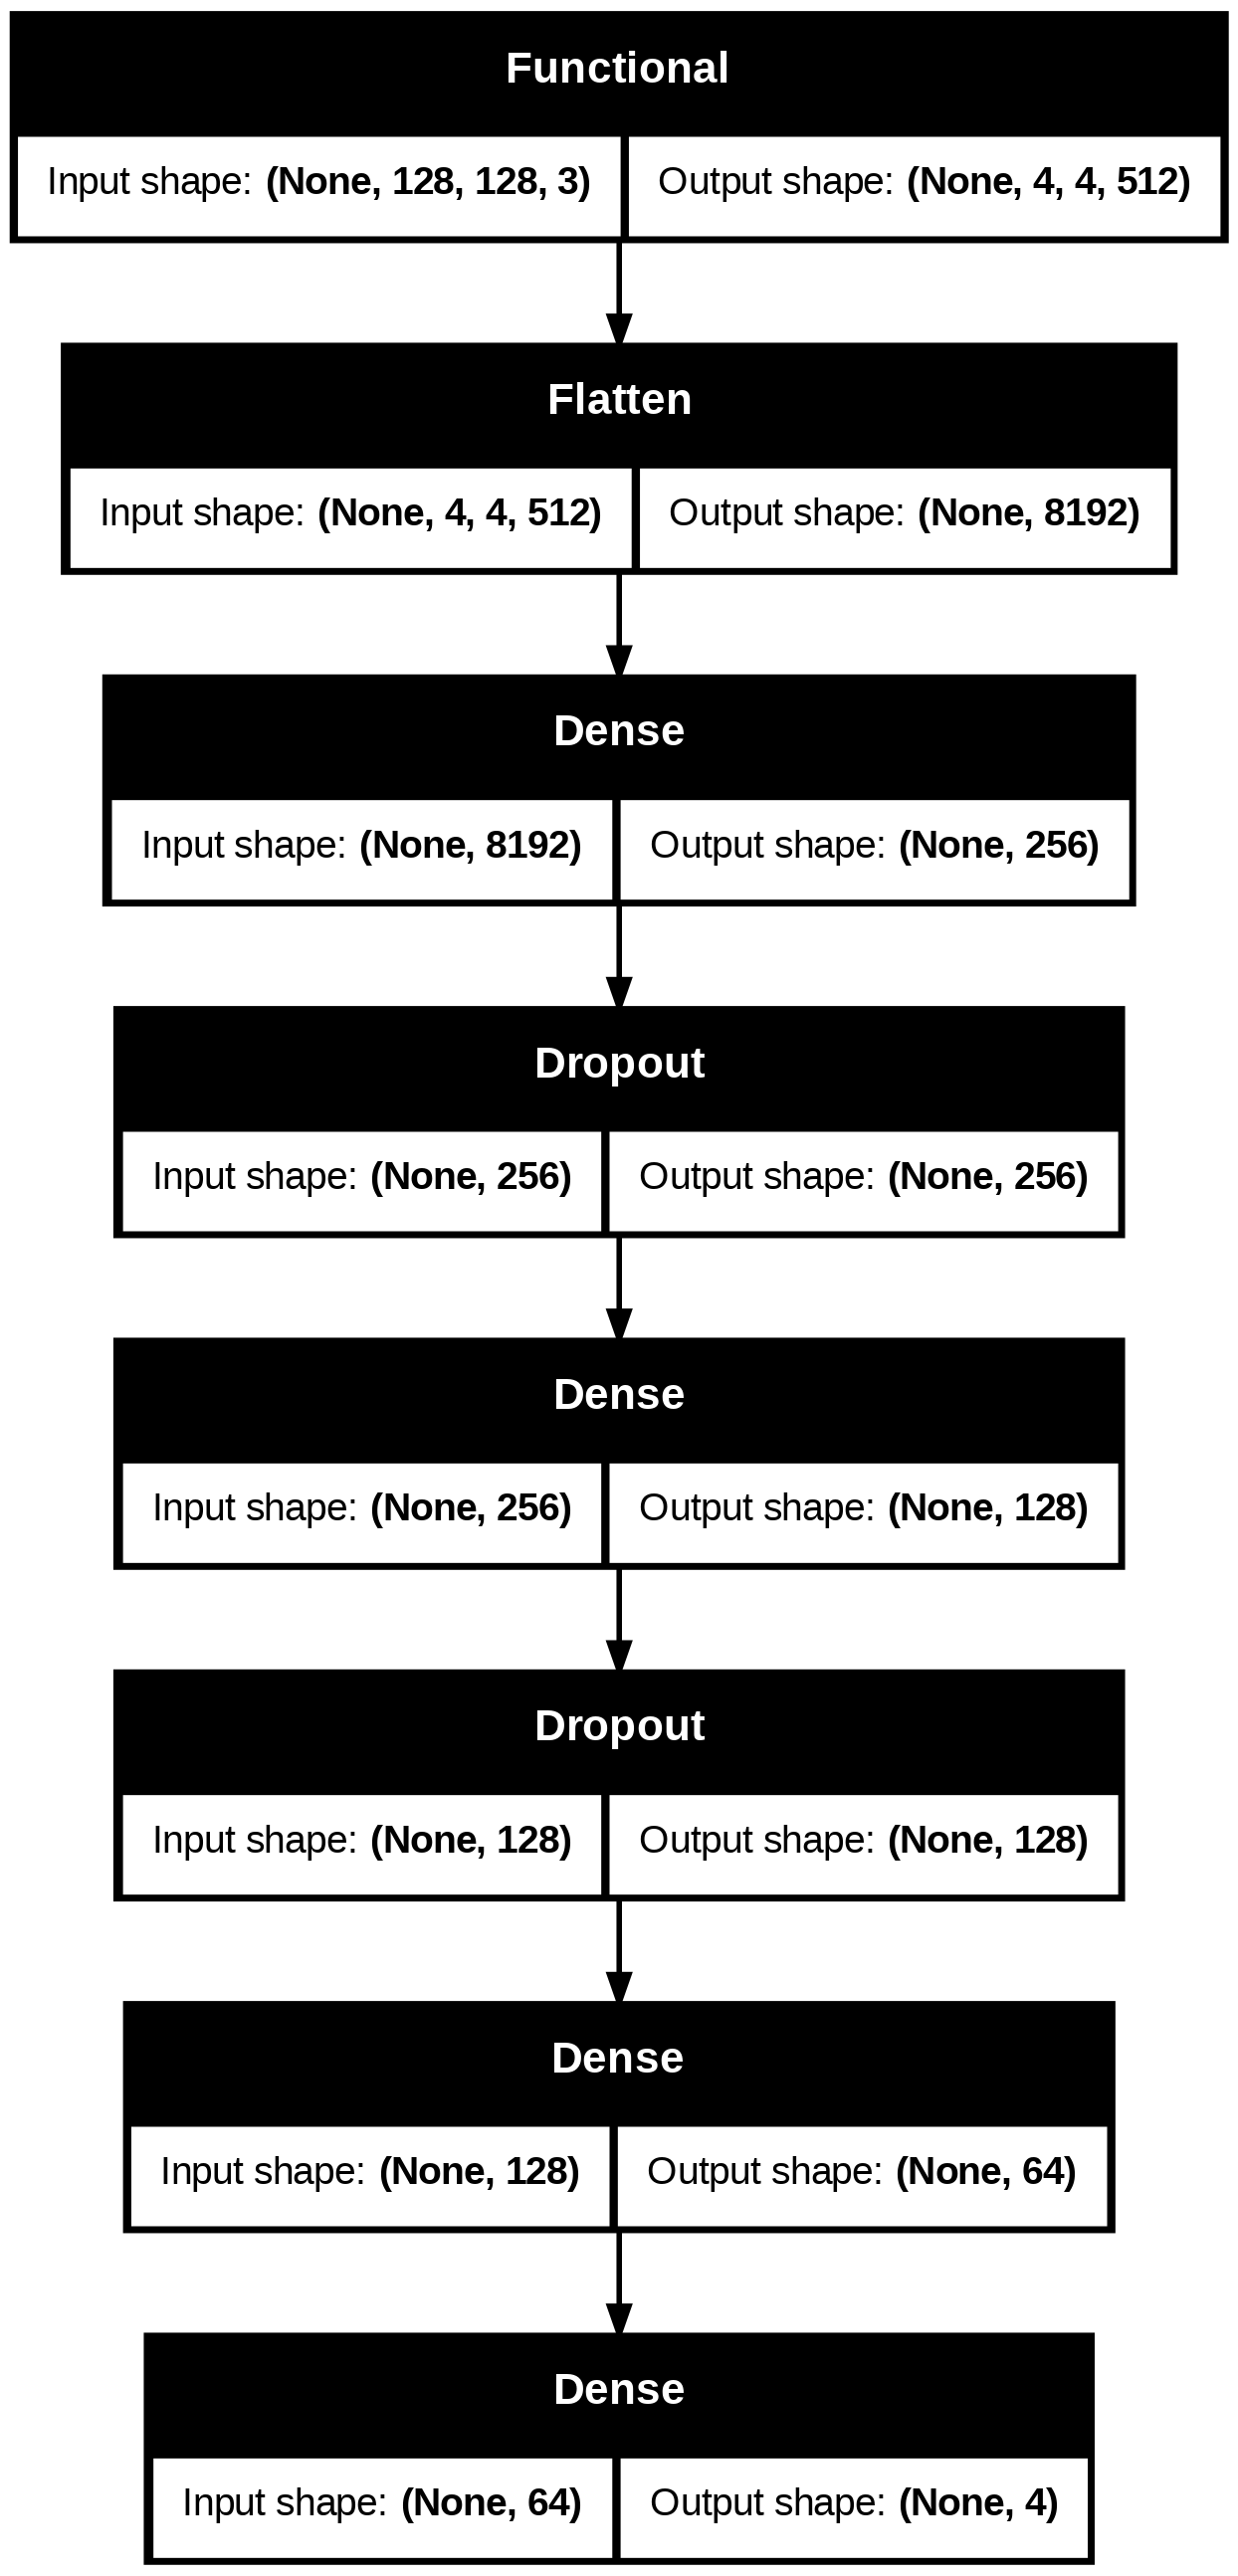

In [24]:
plot_model(model, show_shapes = True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[9.9976832e-01 2.2662070e-04 5.1287834e-06 3.8463798e-12]]
['brain_glioma', 'brain_menin', 'brain_pituitary', 'no_tumor']


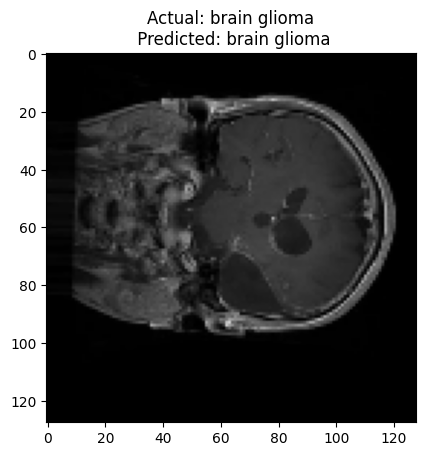

In [25]:
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

test_img_path = './image_dataset_(Brain)/test/brain_glioma/brain_glioma_4736.jpg'

test_img = cv2.imread(test_img_path)
test_img = cv2.resize(test_img, (IMGSIZE, IMGSIZE))

# Convert BGR to RGB for correct display
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

test_img = test_img[tf.newaxis, ...]
test_predict = model.predict(test_img)

# Extract actual label from file name
filename = test_img_path.split(os.path.sep)[-1]
str1 = filename.split('_')[0]
str2 = filename.split('_')[1]

# Extract predicted class
predicted_class = classes[np.argmax(test_predict)]
str3 = predicted_class.split('_')[0] + ' ' + predicted_class.split('_')[1]

plt.title('Actual: ' + str1 + ' ' + str2 + '\n Predicted: ' + str3)

print(test_predict)
print(classes)
plt.show()